<a href="https://colab.research.google.com/github/agmorcillo/Coursera_Capstone/blob/main/Practice_Week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practice Week 3 - Part 1**

### Loading libraries - Part 1

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np

### Scrapping the url using BeautifulSoup

In [2]:
# fetching Wikipedia page data using requests
url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(url, 'lxml')

# looking tables on the Wikipedia page
table = soup.find("table")
table_rows = table.tbody.find_all("tr")



clean = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
    if row != [] and row[1] != "Not assigned\n":
        # If a cell has a borough but a "Not assigned" neighbourhood, then the neighborhood will be the same as the borough.
        if "Not assigned\n" in row[2]: 
            row[2] = row[1]
        clean.append(row)

# Dataframe with the main columns
df = pd.DataFrame(clean, columns = ["PostalCode", "Borough", "Neighbourhood"])

#Cleaning "/n" from de columns Neighbourhood, Borough and PostalCode

df["Neighbourhood"] = df["Neighbourhood"].str.replace("\n","")
df["Borough"] = df["Borough"].str.replace("\n","")
df["PostalCode"] = df["PostalCode"].str.replace("\n","")

df.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


**Group all neighborhoods using postal code**

In [3]:
df = df.groupby(["PostalCode", "Borough"])["Neighbourhood"].apply(", ".join).reset_index()
df.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## **Question 1 Final Answer:**

In [4]:
print("Shape: rows and columns", df.shape)

Shape: rows and columns (103, 3)


# **Practice Week 3 - Part 2**

Loading libraries - Part 2

In [5]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

**Geocoder package:**

In [6]:
df_geo_coor = pd.read_csv("sample_data/Geospatial_Coordinates.csv")
df_geo_coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
# Merge Latitude and Longitude using PostalCode
df_toronto = pd.merge(df, df_geo_coor, how='left', left_on = 'PostalCode', right_on = 'Postal Code')

# delete the PostalCode column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


**How many neighbourhoods in each borough**

In [8]:
df_toronto.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighbourhood, dtype: int64

**Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude**

In [9]:
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


# **Practice Week 3 - Part 3**

## Loading libraries - Part 3

In [10]:
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import lxml

**Get the latitude and longitude of Toronto**

In [11]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


**Create a map of the whole Toronto City with neighborhoods superimposed on top**

In [25]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

**This will color categorize each borough by colors**

In [26]:
boroughs = df_toronto['Borough'].unique().tolist()
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

Add markers to **map**

In [27]:
for lat, lng, borough, neighbourhood in zip(
        df_toronto['Latitude'], 
        df_toronto['Longitude'], 
        df_toronto['Borough'], 
        df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill=True,
        fill_color=borough_color[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

**Map of a part of Toronto City - We will work with boroughs that contain the word Toronto**

In [82]:
df_toronto = df_toronto[df_toronto['Borough'].str.contains("Toronto")].reset_index(drop=True)
print(df_toronto.shape)
df_toronto.head()

(39, 5)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


**Definition foursqueare Credentials**

In [83]:
CLIENT_ID = 'G1MSH1RPBTL4V3BKNUMQN0EDUBL2YEXLHTLKDF13JVW0CFFG' #  Foursquare ID
CLIENT_SECRET = '4RVAIXX4XSSLUZFUXELJW2XH4DUZCL5NKNOZKQBHMAIDY120' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: G1MSH1RPBTL4V3BKNUMQN0EDUBL2YEXLHTLKDF13JVW0CFFG
CLIENT_SECRET:4RVAIXX4XSSLUZFUXELJW2XH4DUZCL5NKNOZKQBHMAIDY120


In [84]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

**Create the GET function venues**

In [85]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
   
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

**Create the GET function for venue details**

In [86]:
def get_venue_details(venue_id):
   
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df 

**List of Comic Shop's in Toronto**

In [87]:
# Prepare neighborhood list that contains Comic Shop
column_names=['Borough', 'Neighborhood', 'ID','Name']
comic_shop_df=pd.DataFrame(columns=column_names)

for row in toronto_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    comic_shop=venues[venues['Category']=='Comic Shop']   
    for comic_shop_detail in comic_shop.values.tolist():
        id, name , category=comic_shop_detail
        comic_shop_df = comic_shop_df.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

comic_shop_df.head(10)

,Borough,Neighborhood,ID,Name
0,East Toronto,"India Bazaar, The Beaches West",55667a68498e74fae3631f5e,The Sidekick
1,Downtown Toronto,Church and Wellesley,55007fd7498ed027fd04b664,Page & Panel: The TCAF Shop
2,Downtown Toronto,"Garden District, Ryerson",4ad4c062f964a5200bf820e3,Silver Snail Comics
3,Downtown Toronto,St. James Town,4ad4c062f964a5200bf820e3,Silver Snail Comics
4,Downtown Toronto,Central Bay Street,4ad4c062f964a5200bf820e3,Silver Snail Comics
5,Downtown Toronto,"Richmond, Adelaide, King",4ad4c062f964a5200bf820e3,Silver Snail Comics
6,Downtown Toronto,"University of Toronto, Harbord",4e4564e0d4c065cb6b90d289,Little Island Comics
7,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",4e4564e0d4c065cb6b90d289,Little Island Comics
8,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4ad4c062f964a5200bf820e3,Silver Snail Comics
9,East Toronto,"Business reply mail Processing Centre, South C...",55667a68498e74fae3631f5e,The Sidekick


**Now we got all the Comic Shop's in the Toronto**

In [101]:
comic_shop_df.shape

(10, 4)




We got 10 Comic Shop'2 across Toronto


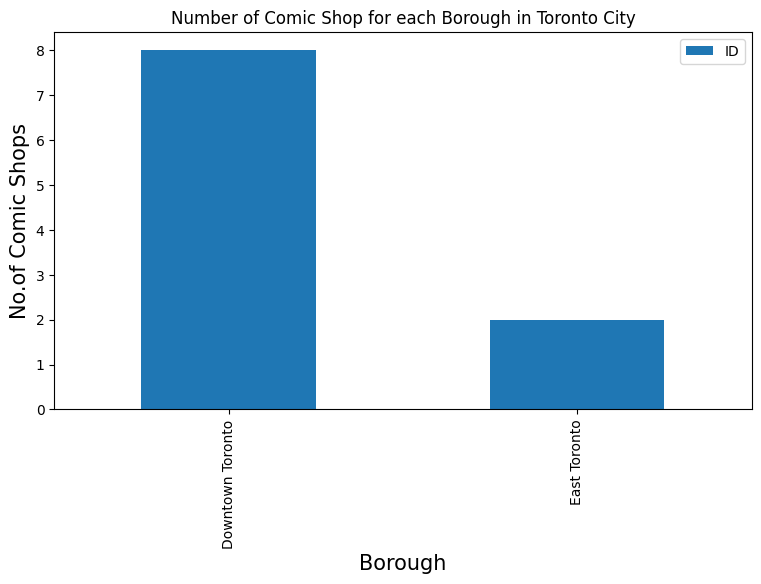

In [89]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Comic Shop for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Comic Shops', fontsize=15)
#giving a bar plot
comic_shop_df.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

**It is noted that Downtown Toronto has the highest number of Comic Shop's.**


In [96]:
comic_shop_df[comic_shop_df['Borough']=='Downtown Toronto']

,Borough,Neighborhood,ID,Name
1,Downtown Toronto,Church and Wellesley,55007fd7498ed027fd04b664,Page & Panel: The TCAF Shop
2,Downtown Toronto,"Garden District, Ryerson",4ad4c062f964a5200bf820e3,Silver Snail Comics
3,Downtown Toronto,St. James Town,4ad4c062f964a5200bf820e3,Silver Snail Comics
4,Downtown Toronto,Central Bay Street,4ad4c062f964a5200bf820e3,Silver Snail Comics
5,Downtown Toronto,"Richmond, Adelaide, King",4ad4c062f964a5200bf820e3,Silver Snail Comics
6,Downtown Toronto,"University of Toronto, Harbord",4e4564e0d4c065cb6b90d289,Little Island Comics
7,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",4e4564e0d4c065cb6b90d289,Little Island Comics
8,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4ad4c062f964a5200bf820e3,Silver Snail Comics


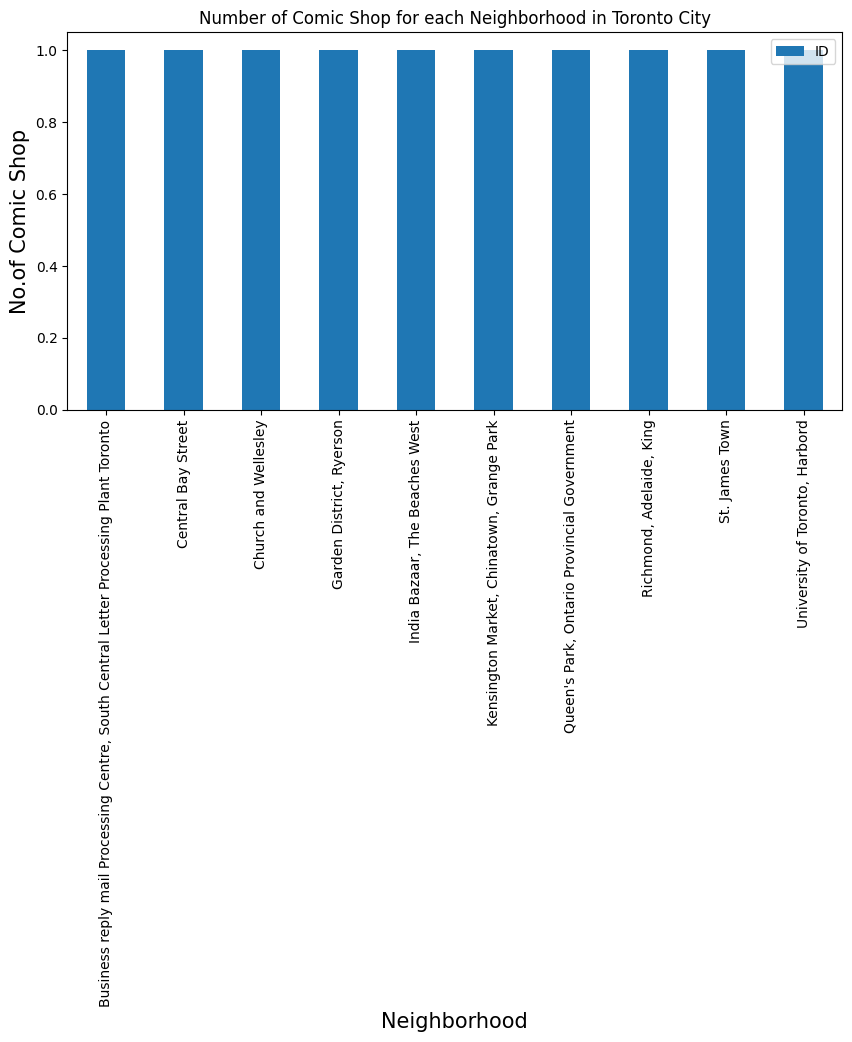

In [90]:
plt.figure(figsize=(10,5), dpi = 100)
# title
plt.title('Number of Comic Shop for each Neighborhood in Toronto City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Comic Shop', fontsize=15)
#giving a bar plot
comic_shop_df.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

**Now we will get the ranking of each Comic Shop for further analysis.**

In [97]:
#prepare neighborhood list that contains Comic Shops
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
comic_shop_stats_df=pd.DataFrame(columns=column_names)
count=1


for row in comic_shop_df.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_to),')','processed')
    comic_shop_stats_df = comic_shop_stats_df.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1



KeyError: ignored

**We need to convert Likes, Tips into float values for further analysis.**


In [61]:
comic_shop_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       10 non-null     object 
 1   Neighborhood  10 non-null     object 
 2   ID            10 non-null     object 
 3   Name          10 non-null     object 
 4   Likes         10 non-null     object 
 5   Rating        10 non-null     float64
 6   Tips          10 non-null     object 
dtypes: float64(1), object(6)
memory usage: 688.0+ bytes


In [63]:
comic_shop_stats_df[['Likes','Tips']]=comic_shop_stats_df[['Likes','Tips']].astype('float64')
comic_shop_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       10 non-null     object 
 1   Neighborhood  10 non-null     object 
 2   ID            10 non-null     object 
 3   Name          10 non-null     object 
 4   Likes         10 non-null     float64
 5   Rating        10 non-null     float64
 6   Tips          10 non-null     float64
dtypes: float64(3), object(4)
memory usage: 688.0+ bytes


In [ ]:
# Comic Shop's with maximum Likes
comic_shop_stats_df.iloc[comic_shop_stats_df['Likes'].idxmax()]

In [ ]:
# Comic Shop's with maximum Rating
comic_shop_stats_df.iloc[comic_shop_stats_df['Rating'].idxmax()]

In [ ]:
# Comic Shop's with maximum Tips
comic_shop_stats_df.iloc[comic_shop_stats_df['Tips'].idxmax()]

**Lets find out average rating of Comic Shops in the particular Neighborhood**

In [ ]:
neighbourhood_stats=comic_shop_stats_df.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
neighbourhood_stats.columns=['Neighborhood','Average Rating']

In [ ]:
neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

**Similarly lets do it for Borough**


In [ ]:
borough_stats=comic_shop_stats_df.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
borough_stats.columns=['Borough','Average Rating']

**Sort them**

In [ ]:
borough_stats.sort_values(['Average Rating'],ascending=False).head()

**Lets visualize it.**

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title("Average rating of Comic Shop's in each Borough")
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
comic_shop_stats_df.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
neighborhood_stats 

Now we will merge the toronto dataset to get Latitude and Longitude

In [ ]:
neighborhood_stats=pd.merge(neighborhood_stats,toronto_data, on='Neighborhood')

In [ ]:
neighborhood_stats=neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [ ]:
neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

In [ ]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [ ]:
neighborhood_stats['Label']=neighborhood_stats['Neighborhood']+', '+neighborhood_stats['Borough']+'('+neighborhood_stats['Average Rating'].map(str)+')'

In [ ]:
# add pop-up text to each marker on the map
for lat, lng, label in neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(map_toronto)        
# add incidents to map
map_toronto.add_child(incidents)